# Data Exploration
## Purpose
State the purpose of the notebook.
## Methodology
Quickly describle assumptions and processing steps.
## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:

- Todo 1;
- Todo 2;

## Results
Describe and comment the most important results.

# Setup
## Library import
We import all the required P
ython libraries

In [191]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
import rasterio
import regionmask
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Utils

**set_lat_lon_attrs**

In [2]:
def set_lat_lon_attrs(ds):
    """ Set CF latitude and longitude attributes"""
    ds["lon"] = ds.lon.assign_attrs({
      'axis' : 'X',
       'long_name' : 'longitude',
        'standard_name' : 'longitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_east',
            'valid_max' : 360.0,
             'valid_min' : -180.0
             })
    ds["lat"] = ds.lat.assign_attrs({
      'axis' : 'Y',
       'long_name' : 'latitude',
        'standard_name' : 'latitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_north',
            'valid_max' : 90.0,
             'valid_min' : -90.0
             })
    return ds


**create_ds_mask**

In [544]:
def create_ds_mask(df, ds, name, lon_name='lon', lat_name='lat'):
    """Create masks of geographical regions"""
    # Create index column
    if 'index' not in df:
        df = df.reset_index(drop=True).reset_index()

    # Extract indexes and geoms that are large enough!
    id_ints = df['index'].values
    geoms = df['geometry'].values
    
    print(f'Number of indexes: {len(id_ints)}')
    print(f'Number of geoms: {len(geoms)}')


    # create mask object
    da_mask = regionmask.Regions(
      name = name,
      numbers = id_ints,
      outlines = geoms)\
      .mask(ds, lon_name=lon_name, lat_name=lat_name)\
      .rename(name)

    # get the ints actually written to mask
    id_ints_mask = da_mask.to_dataframe().dropna()[name].unique()
    id_ints_mask = np.sort(id_ints_mask).astype('int')
    
    print(f'Number of ints in mask: {len(id_ints_mask)}')
    
    # get the ints not written to mask
    id_ints_not_in_mask = df[~df['index'].isin(id_ints_mask)]['index'].values
    
    if len(id_ints_not_in_mask) > 0: 
        print(f'Ints not in mask: {id_ints_not_in_mask}')
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_ints_mask
    da_mask = set_lat_lon_attrs(da_mask)
    
    return da_mask, id_ints_not_in_mask

**find_nearest**

In [577]:
def find_nearest(array, value):
    """Find nearest value in numpy array"""
    array = np.asarray(array)
    
    # Get the mean step values
    step = np.abs(np.diff(array)).max()
    
    # Find the nearest values
    diff = np.abs(array - value)
    idx = np.argwhere((diff >= np.amin(diff) - step) & (diff <= np.amin(diff) + step))

    return idx

**get_xy_from_latlon**

In [822]:
def get_xy_from_latlon(ds, lat, lon):
    """Return the x/y values for a given longitude/latitude values"""
    # Read all lon/lat values
    lons = ds.lon.data
    lats = ds.lat.data
    
    # Find the positions of the nearest longitude/latitude values
    idx_lon = find_nearest(lons, lon)
    idx_lat = find_nearest(lats, lat)
    
    # Check the identical rows in both arrays
    res = (idx_lon[:, None] == idx_lat).all(-1).any(-1)
    yx_positions = idx_lon[res]
    
    
    if yx_positions.shape[0] == 0:
        raise Exception("Sorry, lat/lon values outside data domain")   
    if yx_positions.shape[0] > 1:
        # If more than one identical rows take the row nearest to the mean value
        yx_positions = np.mean(yx_positions,axis=0).astype(int).reshape(1,2)

    # Get the x/y values
    x_position = yx_positions[0][1]
    y_position = yx_positions[0][0]
    x = ds.rlon.data[yx_positions[0][1]]
    y = ds.rlat.data[yx_positions[0][0]]

    return x_position, y_position, x, y

# Data import

## Comarcas Agrarias
**[Data source](https://www.mapa.gob.es/es/cartografia-y-sig/ide/descargas/agricultura/)**

La distribución de la superficie de España en `Comarcas Agrarias` agrupa los territorios en unidades espaciales intermedias entre la provincia y el municipio que sin personalidad jurídico-administrativa alguna, tiene un carácter uniforme desde el punto de vista agrario.

In [850]:
comarcas_agr = gpd.read_file(f'../../datasets/raw/ComarcasAgrarias_tcm30-175866/ComarcasAgrarias.shp')

Remove Canarias, Ceuta, and Melilla

In [851]:
comarcas_agr = comarcas_agr[~comarcas_agr['DS_CCAA'].isin(['Canarias', 'Ceuta', 'Melilla'])]

**Display geometries**

<AxesSubplot:>

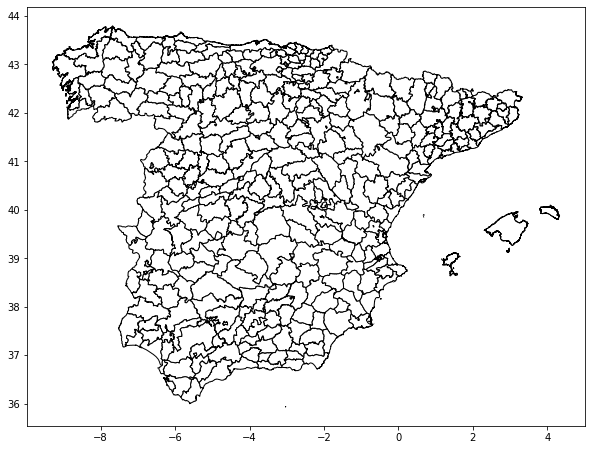

In [852]:
fig, ax = plt.subplots(figsize=(10,10))
comarcas_agr.plot(ax=ax, color='w', edgecolor='k')

<AxesSubplot:>

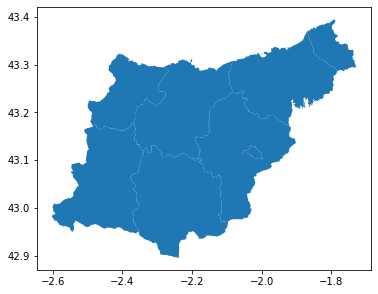

In [59]:
fig, ax = plt.subplots(figsize=(6,6))
comarcas_agr_gp = comarcas_agr[comarcas_agr['DS_PROVINC'] == 'Guipúzcoa'].copy()
comarcas_agr_gp.plot(ax=ax)

## Municipios de España

**[Data source](https://opendata.esri.es/datasets/53229f5912e04f1ba6dddb70a5abeb72_0/explore?location=43.017075%2C9.288571%2C5.20)**

In [853]:
municipios = gpd.read_file(f'../../datasets/raw/Municipios_IGN-shp/Municipios_IGN.shp')

Remove Canarias, Ceuta, and Melilla

In [871]:
municipios = municipios[~municipios['CODNUT2'].isin(['ES7', 'ES63', 'ES64'])]

**Display geometries**

<AxesSubplot:>

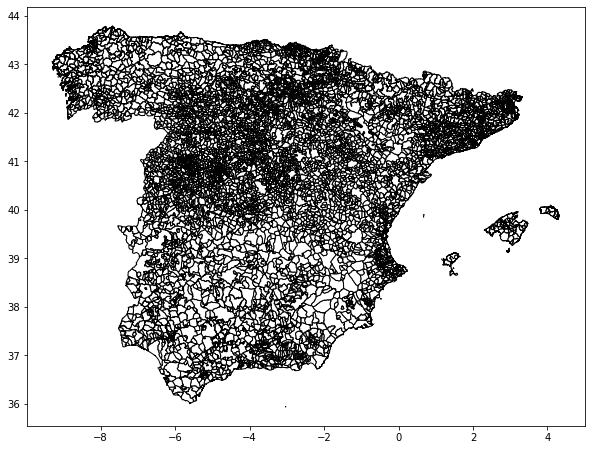

In [872]:
fig, ax = plt.subplots(figsize=(10,10))
municipios.plot(ax=ax, color='w', edgecolor='k')

<AxesSubplot:>

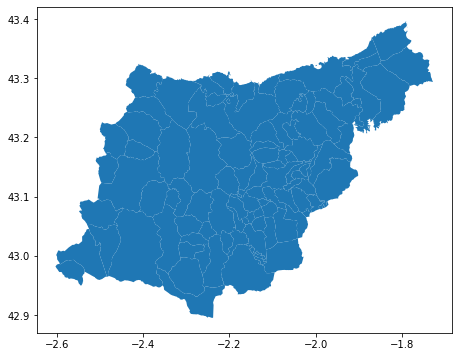

In [268]:
fig, ax = plt.subplots(figsize=(20,6))
municipios_gp =municipios[municipios['CODNUT3']=='ES212'].copy()
municipios_gp.plot(ax=ax)

## Fire danger indicators for Europe 
**[Data source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-tourism-fire-danger-indicators?tab=overview)**

The dataset presents projections of fire danger indicators for Europe based upon the Canadian Fire Weather Index System (FWI) under future climate conditions. The FWI is a meteorologically based index used worldwide to estimate the fire danger and is implemented in the Global ECMWF Fire Forecasting model (GEFF).

**Variables:**
- **Seasonal fire weather index:** 
The mean fire weather index value over the European fire season (June-September). This is calculated as the sum of the daily fire weather index over the European fire season divided by the total number of days within this date range. The higher the index value, the more favorable the meteorological conditions to trigger a wildfire are.

**Read data**

In [60]:
data_dir = '../../datasets/raw/seasonal-fire-weather-index/'
for n, file in enumerate(os.listdir(data_dir)):
    # convert to Dataset and concatenate by time
    if n == 0:
        ds_fire = xr.open_dataset(data_dir+file, engine="netcdf4")
    else:
        ds = xr.open_dataset(data_dir+file, engine="netcdf4")
        ds_fire = xr.concat([ds_fire, ds], dim='time')

In [297]:
ds_fire

<xarray.Dataset>
Dimensions:        (rlon: 424, rlat: 412, time: 78, bnds: 2)
Coordinates:
  * rlon           (rlon) float64 -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
  * rlat           (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
  * time           (time) datetime64[ns] 2020-11-01 2021-11-01 ... 2097-11-01
    lon            (rlat, rlon) float64 -10.06 -9.964 -9.864 ... 64.76 64.96
    lat            (rlat, rlon) float64 21.99 22.03 22.07 ... 66.81 66.75 66.69
Dimensions without coordinates: bnds
Data variables:
    rotated_pole   (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    time_bnds      (time, bnds) datetime64[ns] 2020-11-01 ... 2098-10-31T23:5...
    fwi-mean-jjas  (time, rlat, rlon) float64 33.45 32.92 34.72 ... 1.721 1.813
    mask           (rlat, rlon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/13)
    creation_date:  2019-06-19-T09:24:05Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-mean-jjas
    references:     van Wagner, C. E., (1987). Development and structure of a...
    ...             ...
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

**Multidimensional Coordinates**

The data will derive from a numerical model in which the poles of the model's coordinate system (`logical coordinates`) differ from the earth's true poles (`physical coordinates`). This is typically done when running limited area models, in order to keep the poles as far away as possible from the area that is being modelled. This allows the model's resolution to be roughly uniform over the model domain, as the coordinate system is then approximately cartesian and avoids issues where the meridians converge close to the poles.

In our dataset, the `logical coordinates` are `rlon` and `rlat`, while the physical coordinates are `lon` and `lat`, which represent the latitudes and longitude of the data.

In [62]:
print(ds_fire.rlon.attrs)
print(ds_fire.rlat.attrs)

{'standard_name': 'grid_longitude', 'long_name': 'longitude in rotated pole grid', 'units': 'degrees', 'axis': 'X'}
{'standard_name': 'grid_latitude', 'long_name': 'latitude in rotated pole grid', 'units': 'degrees', 'axis': 'Y'}


In [63]:
print(ds_fire.lon.attrs)
print(ds_fire.lat.attrs)

{'standard_name': 'longitude', 'long_name': 'longitude', 'units': 'degrees_east'}
{'standard_name': 'latitude', 'long_name': 'latitude', 'units': 'degrees_north'}


**Display data**

Xarray provides [several ways](http://xarray.pydata.org/en/stable/examples/multidimensional-coords.html) to plot and analyze such datasets.

If we try to plot the data variable `fwi-mean-jjas`, by default we get the logical coordinates.

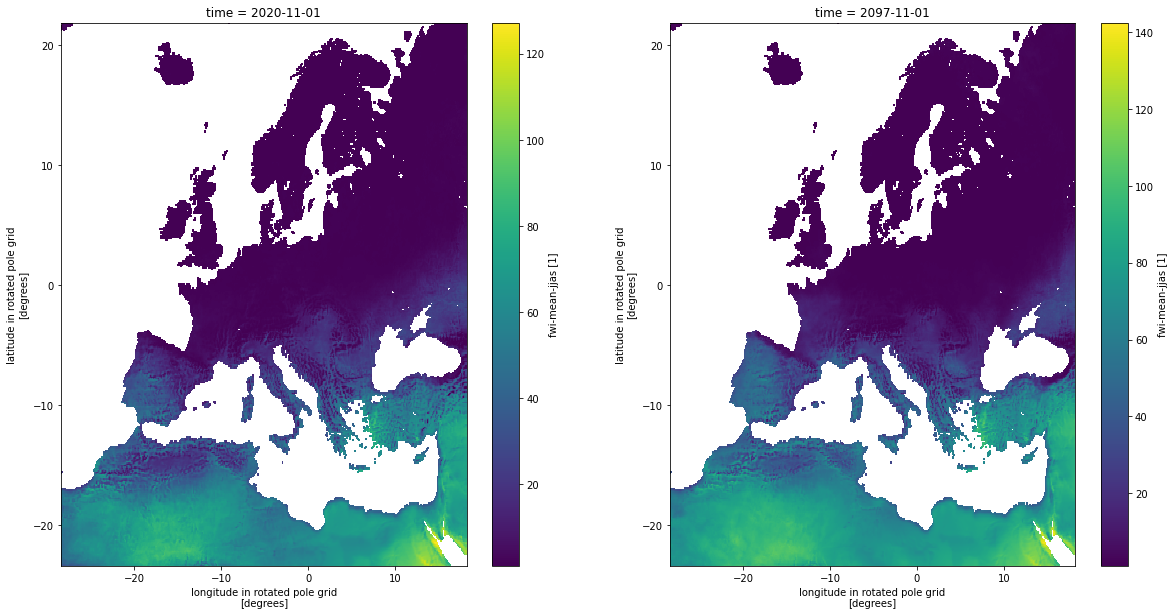

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
ds_fire['fwi-mean-jjas'].isel(time=0).plot(ax=axs[0])
ds_fire['fwi-mean-jjas'].isel(time=77).plot(ax=axs[1])

In order to visualize the data on a conventional latitude-longitude grid, we can take advantage of xarray’s ability to apply [cartopy](http://scitools.org.uk/cartopy/index.html) map projections.

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


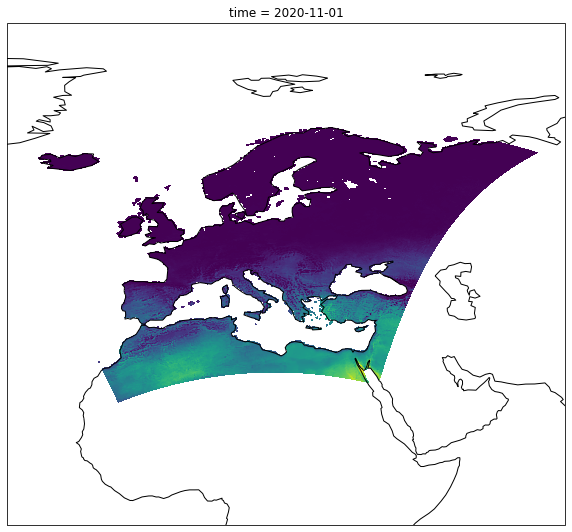

In [65]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds_fire['fwi-mean-jjas'].isel(time=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False)
ax.coastlines()
ax.set_ylim([0,90]);
ax.set_xlim([-30,70]);

## Rasterize vector data

### Compute mean values for each `comarca agraria`

**Create the data mask by rasterizing the vector data**

In [873]:
gdf = comarcas_agr.copy()
gdf = gdf.reset_index(drop=True)
da_mask, id_ints_not_in_mask = create_ds_mask(gdf, ds_fire, name='mask', lon_name='lon', lat_name='lat')

Number of indexes: 346
Number of geoms: 346
Number of ints in mask: 333
Ints not in mask: [ 97 102 104 107 119 121 123 124 195 209 210 218 243]


In [874]:
da_mask

<xarray.DataArray 'mask' (rlat: 412, rlon: 424)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * rlat     (rlat) float64 -23.38 -23.27 -23.16 -23.05 ... 21.62 21.73 21.84
  * rlon     (rlon) float64 -28.38 -28.27 -28.16 -28.05 ... 17.94 18.05 18.16
    lat      (rlat, rlon) float64 21.99 22.03 22.07 22.11 ... 66.81 66.75 66.69
    lon      (rlat, rlon) float64 -10.06 -9.964 -9.864 ... 64.55 64.76 64.96
Attributes:
    id_ints:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  1...

**Add geometries smaller than mean cell size into the mask**

In [876]:
gdf_not_in_mask = gdf.iloc[id_ints_not_in_mask].copy()

gdf_not_in_mask['centroid'] = gdf_not_in_mask['geometry'].apply(lambda x: x.centroid)

for id_int in id_ints_not_in_mask:
    lon = gdf_not_in_mask['centroid'].loc[id_int].x
    lat = gdf_not_in_mask['centroid'].loc[id_int].y
    
    # Get x/y values for the corresponding longitude/latitude values
    x_pos, y_pos, x, y = get_xy_from_latlon(ds_fire, lat, lon)
    
    # Replace cell value with new int
    da_mask.data[y_pos, x_pos] = id_int
    
# update da attributes
da_mask.attrs['id_ints'] = list(gdf.index)

**Display mask**

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


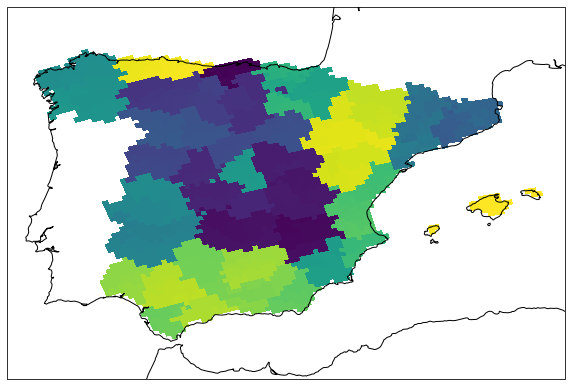

In [877]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
da_mask.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False)
ax.coastlines()
ax.set_ylim([35, 45]);
ax.set_xlim([-10, 5]);

**Add mask as a new variable into the xarray.Dataset**

In [878]:
ds_fire['mask'] = da_mask

**Compute mean value over time**

In [879]:
mean_values = [] 
for index in gdf.index:
    mean_values.append(ds_fire['fwi-mean-jjas'].where(ds_fire.mask == index).mean(['rlon', 'rlat']).values)
    
gdf['fire'] = mean_values
gdf['time'] = [list(ds_fire.coords['time'].values)]*len(mean_values)

**Display values for a single year**

In [880]:
year = 0
gdf_1year = gdf.copy()
gdf_1year['fire'] = gdf_1year['fire'].apply(lambda x: x[year])
gdf_1year['time'] = gdf_1year['time'].apply(lambda x: x[year])

Text(0.5, 1.0, '2020-11-01 00:00:00')

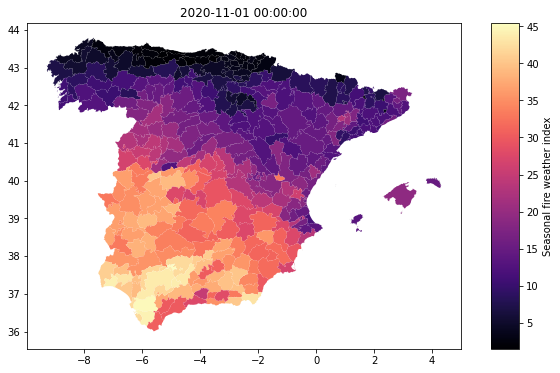

In [881]:
fig, ax = plt.subplots(figsize=(10,10))

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=-0.5)

gdf_1year.plot(ax=ax, column='fire', cmap='magma', legend=True, cax=cax, legend_kwds={'label': "Seasonal fire weather index"})

ax.set_title(str(gdf_1year['time'].iloc[0]))

## Frescor Nocturno 

In [3]:
gdf = gpd.read_file('../../datasets/raw/vino/Resumen FRESCOR.dbf')
gdf

,DENOMINACI,LONG,LAT,ALTURA,N1971_2000,MM5_CNCM3_,MM5_CNCM32,MM5_ECHAM_,MM5_ECHAM2,MM5_ECHAM3,...,REM_ECHAM2,WRA_ECHAM5,WRA_ECHAM2,WRB_ECHAM5,MEDIA,VARIACI_N,A1B,A2,B1,geometry
0,1.0,-5.6,36.0,228.93,19.00,19.40,20.66,19.74,20.61,19.55,...,20.04,20.41,19.78,20.28,20.26,1.26,20.37,20.10,20.14,None
1,2.0,-5.4,36.0,143.71,18.92,19.29,20.55,19.63,20.50,19.43,...,19.93,20.30,19.67,20.16,20.15,1.23,20.26,19.99,20.03,None
2,3.0,-6.0,36.2,62.26,19.95,20.49,21.63,20.66,21.59,20.57,...,20.97,21.32,20.71,21.31,21.31,1.36,21.44,21.09,21.17,None
3,4.0,-5.8,36.2,75.97,19.14,19.67,20.80,19.83,20.76,19.74,...,20.16,20.49,19.88,20.48,20.48,1.34,20.60,20.26,20.35,None
4,5.0,-5.6,36.2,270.90,18.01,18.52,19.59,18.70,19.60,18.54,...,19.01,19.39,18.76,19.25,19.26,1.26,19.38,19.08,19.11,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,1441.0,-5.4,43.6,114.55,14.62,15.30,15.96,15.85,16.13,15.67,...,15.59,16.03,15.79,15.86,15.97,1.36,16.10,15.94,15.73,None
1441,1442.0,-5.2,43.6,41.89,14.75,15.44,16.09,15.99,16.26,15.81,...,15.78,16.25,15.97,16.14,16.14,1.39,16.29,16.06,15.86,None
1442,1443.0,-8.0,43.8,275.28,12.96,13.49,14.13,14.04,13.97,13.76,...,13.79,13.99,14.03,13.96,14.08,1.12,14.20,14.01,13.86,None
1443,1444.0,-7.8,43.8,88.86,12.78,13.30,13.95,13.85,13.78,13.57,...,13.60,13.81,13.80,13.76,13.89,1.11,14.01,13.81,13.68,None


In [4]:
gdf = gpd.read_file('../../datasets/raw/vino/Resumen Huglin.dbf')
gdf

,DENOMINACI,LONG,LAT,ALTURA,N1971_2000,MM5_CNCM3_,MM5_CNCM32,MM5_ECHAM_,MM5_ECHAM2,MM5_ECHAM3,...,REM_ECHAM2,WRA_ECHAM5,WRA_ECHAM2,WRB_ECHAM5,MEDIA,VARIACI_N,A1B,A2,B1,geometry
0,1.0,-5.6,36.0,228.93,2079.05,2139.58,2338.85,2292.46,2202.09,2245.10,...,2319.93,2301.69,2198.82,2286.39,2306.05,227.00,2322.15,2211.63,2327.29,None
1,2.0,-5.4,36.0,143.71,2150.34,2209.19,2408.43,2362.02,2271.82,2314.78,...,2383.64,2371.20,2268.36,2356.06,2376.45,226.12,2392.96,2286.38,2394.18,None
2,3.0,-6.0,36.2,62.26,2317.59,2481.43,2604.15,2534.26,2457.54,2490.41,...,2567.55,2515.93,2439.13,2516.86,2565.03,247.44,2585.36,2458.09,2584.47,None
3,4.0,-5.8,36.2,75.97,2341.20,2503.37,2626.09,2556.28,2479.52,2512.44,...,2585.23,2537.96,2461.18,2538.86,2586.96,245.76,2607.63,2480.11,2605.60,None
4,5.0,-5.6,36.2,270.90,2166.85,2298.68,2423.58,2385.83,2278.80,2322.42,...,2404.43,2386.20,2283.24,2371.02,2397.34,230.49,2419.70,2293.55,2410.43,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,1441.0,-5.4,43.6,114.55,1482.62,1662.59,1701.02,1612.44,1599.10,1653.01,...,1678.35,1626.66,1629.98,1622.22,1693.18,210.56,1698.11,1645.05,1711.21,None
1441,1442.0,-5.2,43.6,41.89,1595.80,1780.42,1818.95,1730.29,1716.93,1770.92,...,1837.07,1757.79,1770.63,1758.06,1802.61,206.81,1807.50,1757.12,1819.15,None
1442,1443.0,-8.0,43.8,275.28,1237.81,1407.65,1426.57,1342.47,1346.44,1380.74,...,1423.58,1349.80,1378.54,1346.43,1404.75,166.93,1409.99,1369.06,1414.63,None
1443,1444.0,-7.8,43.8,88.86,1434.68,1608.36,1627.31,1543.13,1547.16,1581.52,...,1624.43,1553.41,1562.20,1549.57,1604.90,170.22,1611.24,1564.11,1615.43,None


In [5]:
gdf = gpd.read_file('../../datasets/raw/vino/Resumen IS.dbf')
gdf

,DENOMINACI,LONG,LAT,ALTURA,N1971_2000,MM5_CNCM3_,MM5_CNCM32,MM5_ECHAM_,MM5_ECHAM2,MM5_ECHAM3,...,REM_ECHAM2,WRA_ECHAM5,WRA_ECHAM2,WRB_ECHAM5,MEDIA,VARIACI_N,A1B,A2,B1,geometry
0,1.0,-5.6,36.0,228.93,47.67,46.84,49.83,23.14,35.20,48.10,...,12.43,9.71,22.36,10.19,20.20,-27.47,12.39,30.17,31.40,None
1,2.0,-5.4,36.0,143.71,47.32,28.75,30.80,5.47,17.49,30.05,...,4.21,-7.81,4.63,-7.30,2.60,-44.72,-5.18,9.81,15.39,None
2,3.0,-6.0,36.2,62.26,44.07,11.32,25.34,9.17,17.61,29.53,...,5.93,-2.23,4.64,-2.59,4.21,-39.85,-4.62,17.79,15.49,None
3,4.0,-5.8,36.2,75.97,28.97,-7.71,4.27,-10.56,-1.52,9.46,...,-23.46,-20.03,-12.66,-20.23,-16.17,-45.14,-24.62,-1.73,-6.22,None
4,5.0,-5.6,36.2,270.90,51.98,13.53,29.24,1.27,22.25,32.04,...,-3.95,-5.73,7.71,-5.03,0.90,-51.08,-8.46,14.43,13.37,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,1441.0,-5.4,43.6,114.55,257.09,183.43,194.64,217.44,232.54,221.34,...,190.14,210.01,207.84,209.20,196.37,-60.73,192.64,211.83,195.27,None
1441,1442.0,-5.2,43.6,41.89,255.20,179.07,189.55,212.05,226.88,215.91,...,189.63,204.92,201.07,203.94,192.25,-62.95,187.25,211.48,191.73,None
1442,1443.0,-8.0,43.8,275.28,350.15,252.18,270.30,313.03,314.19,319.58,...,283.15,306.43,295.78,304.07,289.40,-60.75,287.32,295.82,290.13,None
1443,1444.0,-7.8,43.8,88.86,260.76,162.54,178.97,218.90,220.19,225.53,...,195.74,207.20,203.36,205.45,198.40,-62.35,195.89,204.78,200.10,None


In [7]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1445 entries, 0 to 1444
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   DENOMINACI  1445 non-null   float64 
 1   LONG        1445 non-null   float64 
 2   LAT         1445 non-null   float64 
 3   ALTURA      1445 non-null   float64 
 4   N1971_2000  1445 non-null   float64 
 5   MM5_CNCM3_  1445 non-null   float64 
 6   MM5_CNCM32  1445 non-null   float64 
 7   MM5_ECHAM_  1445 non-null   float64 
 8   MM5_ECHAM2  1445 non-null   float64 
 9   MM5_ECHAM3  1445 non-null   float64 
 10  MM5_HADCM3  1445 non-null   float64 
 11  MM5_HADCM2  1445 non-null   float64 
 12  PRO_CNCM3_  1445 non-null   float64 
 13  PRO_CNCM32  1445 non-null   float64 
 14  PRO_ECHAM_  1445 non-null   float64 
 15  PRO_ECHAM2  1445 non-null   float64 
 16  PRO_ECHAM3  1445 non-null   float64 
 17  PRO_HADCM3  1445 non-null   float64 
 18  PRO_HADCM2  1445 non-null   float64 
 19

## Mapas de presencia de especies forestales en España peninsular

In [15]:
xda = xr.open_rasterio(f'../../datasets/raw/especies_forestales/g724_mfe_pres/quer_sube.tif').squeeze().drop("band")

In [16]:
xda

<xarray.DataArray (y: 770, x: 1241)>
[955570 values with dtype=int16]
Coordinates:
  * y        (y) float64 43.87 43.86 43.85 43.84 ... 35.94 35.93 35.92 35.91
  * x        (x) float64 -9.375 -9.364 -9.354 -9.344 ... 3.433 3.443 3.453 3.464
Attributes:
    transform:               (0.010353731958507997, 0.0, -9.380001973858, 0.0...
    crs:                     +init=epsg:4326
    res:                     (0.010353731958507997, 0.010353731958508004)
    is_tiled:                0
    nodatavals:              (-32767.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    units:                   ('metre',)
    AREA_OR_POINT:           Point
    TIFFTAG_MAXSAMPLEVALUE:  1
    TIFFTAG_MINSAMPLEVALUE:  0

In [17]:
# convert to Dataset
xds = xr.Dataset({'quer_sube': xda}, attrs=xda.attrs)

In [18]:
xds

<xarray.Dataset>
Dimensions:    (y: 770, x: 1241)
Coordinates:
  * y          (y) float64 43.87 43.86 43.85 43.84 ... 35.94 35.93 35.92 35.91
  * x          (x) float64 -9.375 -9.364 -9.354 -9.344 ... 3.443 3.453 3.464
Data variables:
    quer_sube  (y, x) int16 ...
Attributes:
    transform:               (0.010353731958507997, 0.0, -9.380001973858, 0.0...
    crs:                     +init=epsg:4326
    res:                     (0.010353731958507997, 0.010353731958508004)
    is_tiled:                0
    nodatavals:              (-32767.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    units:                   ('metre',)
    AREA_OR_POINT:           Point
    TIFFTAG_MAXSAMPLEVALUE:  1
    TIFFTAG_MINSAMPLEVALUE:  0

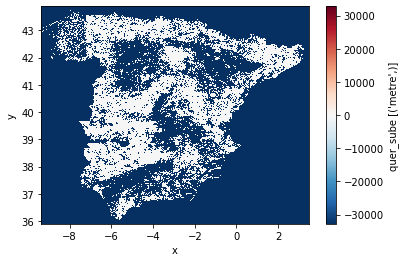

In [19]:
xds.quer_sube.plot()

In [24]:
xr.combine_by_coords([ds_fire, xds])

<xarray.Dataset>
Dimensions:        (rlon: 424, rlat: 412, time: 78, bnds: 2, y: 770, x: 1241)
Coordinates:
  * rlon           (rlon) float64 -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
  * rlat           (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
  * time           (time) datetime64[ns] 2020-11-01 2021-11-01 ... 2097-11-01
    lon            (rlat, rlon) float64 -10.06 -9.964 -9.864 ... 64.76 64.96
    lat            (rlat, rlon) float64 21.99 22.03 22.07 ... 66.81 66.75 66.69
  * y              (y) float64 43.87 43.86 43.85 43.84 ... 35.93 35.92 35.91
  * x              (x) float64 -9.375 -9.364 -9.354 -9.344 ... 3.443 3.453 3.464
Dimensions without coordinates: bnds
Data variables:
    rotated_pole   (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    time_bnds      (time, bnds) datetime64[ns] 2020-11-01 ... 2098-10-31T23:5...
    fwi-mean-jjas  (time, rlat, rlon) float64 33.45 32.92 34.72 ... 1.721 1.813
    quer_sube      (y, x) int16 ...
Attributes: (12/24)
    creation_date:           2019-06-19-T09:24:05Z
    Frequency:               Annual
    institution:             National Observatory of Athens, URL: http://www....
    contact:                 cgiannak@noa.gr
    title:                   fwi-mean-jjas
    references:              van Wagner, C. E., (1987). Development and struc...
    ...                      ...
    scales:                  (1.0,)
    offsets:                 (0.0,)
    units:                   ('metre',)
    AREA_OR_POINT:           Point
    TIFFTAG_MAXSAMPLEVALUE:  1
    TIFFTAG_MINSAMPLEVALUE:  0